<a href="https://colab.research.google.com/github/VincentK1991/BERT_summarization_1/blob/master/notebook/training_BERT_keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning BERT token classification for keyword extraction

This notebook illustrates how to fine-tune BERT for token classification/extraction. This notebook is adapted from the keyword extraction work by Ishaan Batra. The original work is in the Github [here](https://github.com/ibatra/BERT-Keyword-Extractor/blob/master/BERT-Keyword%20Extractor.ipynb)

The training dataset can be found [here](https://www.kaggle.com/akshay235/bert-implementation-on-ner-corpus?select=ner_dataset.csv)

This notebook consists of 4 main sections
1. import packages, data, and pre-trained model
2. tokenization
3. fine-tuning the model
4. result visualization

At the end of this session, we will get a tensor file that can be subsequently used for keyword extraction as part of our GPT2 summarizer model. We will save the tensor file to resource folder under pytorch_model.bin file so that we can use it later.

# import packages, data, and pre-traine model

## 1.1 import packages

In [ ]:
!pip install transformers==2.6.0

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW
assert transformers.__version__ == "2.6.0", "Huggingface transformer version is 2.6.0"

In [ ]:
%tensorflow_version 1.x
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
print(torch.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
1.8.0+cu101


In [ ]:
!pip install seqeval
from seqeval.metrics import f1_score
import timeit
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=fdb12039f51e4502cfa22d62b3c2cdea0014f323b8eda6988152a49370892f09
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


## 1.2 import data

In [ ]:
data = pd.read_csv("resources/POS_tagging/ner_dataset.csv", encoding="latin1").fillna(method="ffill")

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[1] for s in sentence] for sentence in getter.sentences]

In [ ]:
with open('POS_tagging/POS2idx.json', 'r') as fp:
    POS2idx = json.load(fp)
list_POS = ["FW","JJ","NN","NNS","NNP","VB","VBD","VBG","VBN","VBZ","VBP"]
POS_values = list(POS2idx.keys())

# 2. tokenization

we limit the length of input at 120 to reduce the training time. This can be done because the training sentences are usually shorter than 120 tokens.

## 2.1 load the tokenizer

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer2.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
MAX_LEN = 120 # max_len of tokens
bs = 64  # batch_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
tokenizer2 = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

## 2.2 collate the tokenized data to form training and validation dataset

In [ ]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

input_ids = pad_sequences([tokenizer2.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

tags = pad_sequences([[POS2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=POS2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != POS2idx["PAD"]) for i in ii] for ii in input_ids]

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
BERT_model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(POS2idx),
    output_attentions = False,
    output_hidden_states = False)
BERT_model = BERT_model.to(device)

# 3. Fine-tuning BERT token classifier

## 3.1 set up the fine-tuning parameters

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(BERT_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(BERT_model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,        
    lr=3e-5,
    eps=1e-8
)
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    
    num_training_steps=total_steps
)

In [ ]:
counter = 0
print_every = 400
len(train_dataloader.dataset)

43163

## 3.2 perform the fine-tuning

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
start = timeit.default_timer()
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    
    # Put the model into training mode.
    BERT_model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        counter += 1
        if counter % print_every == 0:
          stop = timeit.default_timer()
          print('400 iterations takes {:.3f}'.format(stop - start),' sec')
          start = timeit.default_timer()
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        BERT_model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = BERT_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()    
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=BERT_model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    
    # Put the model into evaluation mode
    BERT_model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = BERT_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    
    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [POS_values[p_i] for p in predictions for p_i in p]
    valid_tags = [POS_values[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print()

# 4. Visualization

we check the result quickly by looking at the confusion matrix

In [ ]:
test_sentence = """
Since 1830, Mauviel has manufactured the highest quality of copper cookware for professional and commercial markets. Mauviel offers cookware manufactured in copper, stainless steel and aluminum that is unsurpassed in quality and design - praised by professional chefs and household cooks.
"""
tokenized_sentence = tokenizer2.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).to(device)

with torch.no_grad():
    output = BERT_model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer2.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(POS_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

In [ ]:
BERT_model.eval()
# Reset the validation loss for this epoch.
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = BERT_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Calculate the accuracy for this batch of test sentences.
    eval_loss += outputs[0].mean().item()
    eval_accuracy += flat_accuracy(logits, label_ids)
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)
    
    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

true_label_list = []
for i in range(len(true_labels)):
  for j in range(len(true_labels[i])):
    true_label_list.append(list(true_labels[i][j]))

In [ ]:
array_true = np.array(true_label_list)
array_true = array_true.flatten()
array_prediction = np.array(predictions)
array_prediction = array_prediction.flatten()

array_confuse = confusion_matrix(array_true, array_prediction,normalize='true')

Text(0.5, 1.0, 'confusion_matrix_POS_tagging_Pytorch_Apr22_2020')

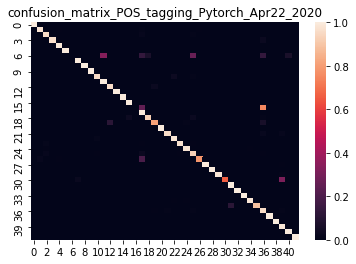

In [ ]:
sns.heatmap(array_confuse)
plt.title('resources/POS_tagging/confusion_matrix_BERT_POS_tagging')

Finally we can save the fine-tuned tensor file for later use

In [ ]:
torch.save(model2.state_dict(), 'resources/POS_tagging/pytorch_model.bin')

# Citation

1. using BERT for keyword extraction from [Ishaan Batra](https://github.com/ibatra/BERT-Keyword-Extractor/blob/master/BERT-Keyword%20Extractor.ipynb)

2. dataset on BERT for part of speech tagging task and named-entity recognition task can be found on [kaggle](https://www.kaggle.com/akshay235/bert-implementation-on-ner-corpus?select=ner_dataset.csv)